In [1]:
import os.path

import numpy as np
import pandas as pd
from scipy import signal
import matplotlib.pyplot as plt
import mne
from mne.preprocessing import ICA
import mne_icalabel
import copy


In [2]:
def load(ok=False):
    def load_fif_file(file_path):
        raw = mne.io.read_raw_fif(file_path, preload=True)
        return raw
    file_path="C:/Users/ROG/Desktop/Pipeline"
    print(os.listdir(file_path))
    for file in os.listdir(file_path):
        if file.endswith(".fif"):
            raw = load_fif_file(os.path.join(file_path,file))
            if ok==True:
                for channel in raw.ch_names:
                    channel_data = raw.copy().pick_channels([channel]).get_data()
                    plt.figure()
                    plt.plot(channel_data[0])
                    plt.title(f'Channel: {channel}')
                    plt.show()
            return raw


In [36]:
class pipeliune:
    def __init__(self, raw, fs=250, cutoff=1):
        self.raw = raw
        self.fs = fs
        self.cutoff = cutoff
    def butter_highpass_filter(self, order=5):
        filt_raw = self.raw.copy().filter(l_freq=1.0, h_freq=None)
        return filt_raw

    def notch_filter(self):
        data_highpass = self.butter_highpass_filter()
        filt_raw = data_highpass.copy().notch_filter([48, 52], picks="eeg", filter_length="auto", phase="zero", verbose=True)
        return filt_raw


    def IC_label(self):
        raw_notch_filtered = self.notch_filter()
        filt_raw = raw_notch_filtered.set_eeg_reference("average")

        ica = ICA(
            n_components=6,
            max_iter="auto",
            method="infomax",
            random_state=97,
            fit_params=dict(extended=True),
        )
        ica.fit(filt_raw)

        # Apply the ICA to the raw data
        raw_ica_applied = ica.apply(filt_raw.copy())

        ic_labels = mne_icalabel.label_components(raw_ica_applied, ica, method="iclabel")
        #Plot the ica components
        ica.plot_components()
        labels = ic_labels["labels"]
        exclude_idx = [
            idx for idx, label in enumerate(labels) if label not in ["brain", "other"]
        ]
        print(f"Excluding these ICA components: {exclude_idx}")
        print(ic_labels["labels"])
        print(raw_ica_applied.get_data().shape)
        reconst_raw = self.raw.copy()
        ica.apply(reconst_raw, exclude=exclude_idx)
        return ica, reconst_raw
    def windowing(self):
        ica,raw_ica_applied=self.IC_label()
        window_size = 1
        a=mne.make_fixed_length_epochs(raw_ica_applied, duration=window_size, preload=True)
        return a
    def base_line_removal(self):
        epochs=self.windowing()
        # baseline correction
        inteval = (0, 0.1)
        bc_epochs = epochs.apply_baseline(inteval)

        # Plot of baseline-corrected evoked signal
        bc_epochs.average().plot()

In [37]:

raw=load()
#raw.plot()
pip = pipeliune(raw)


['.git', '.idea', 'kms-raw.fif', 'ok.py', 'Pipeline.ipynb', 'pipeline.py', '__pycache__']


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    0.0s finished


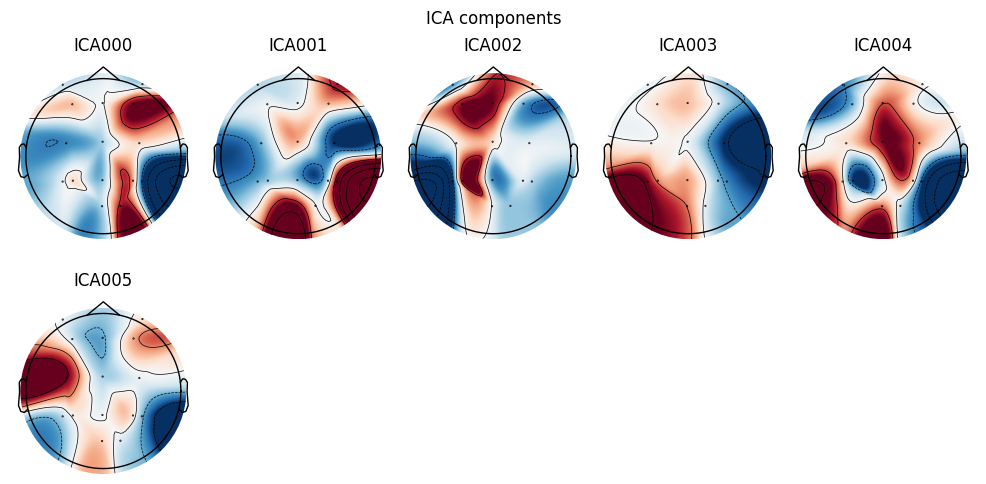

Excluding these ICA components: []
['other', 'other', 'other', 'brain', 'other', 'other']
(21, 2525)


In [38]:
a,b=pip.IC_label()

In [7]:
#Get all components
c=a.get_components()

In [49]:
a.plot_sources(b, show_scrollbars=False, show=True)

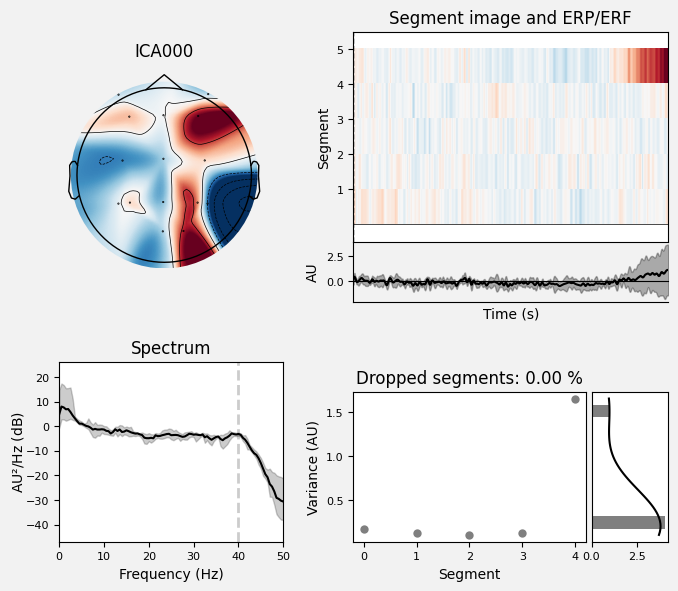

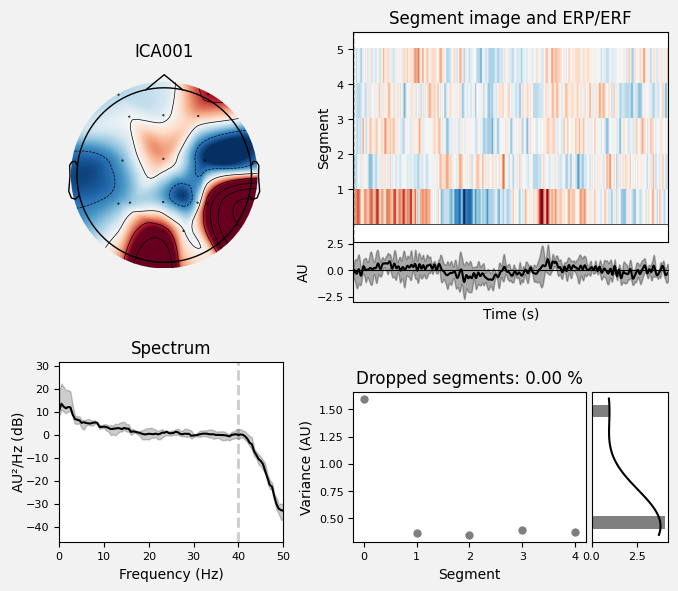

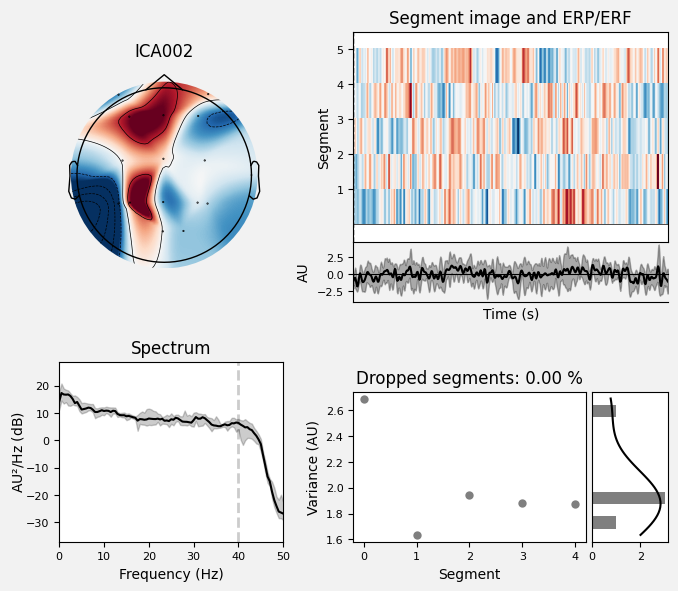

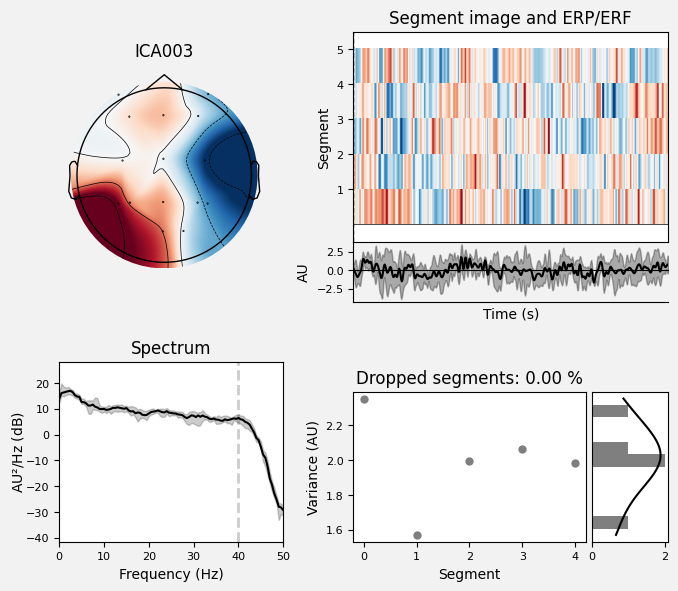

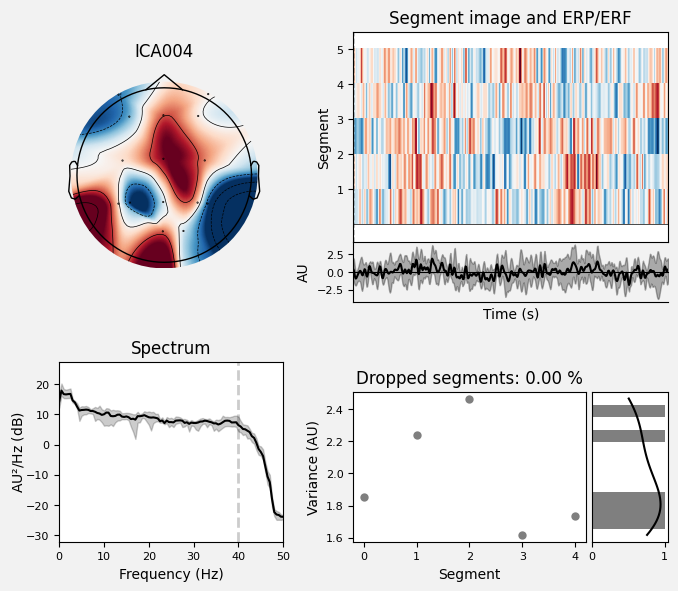

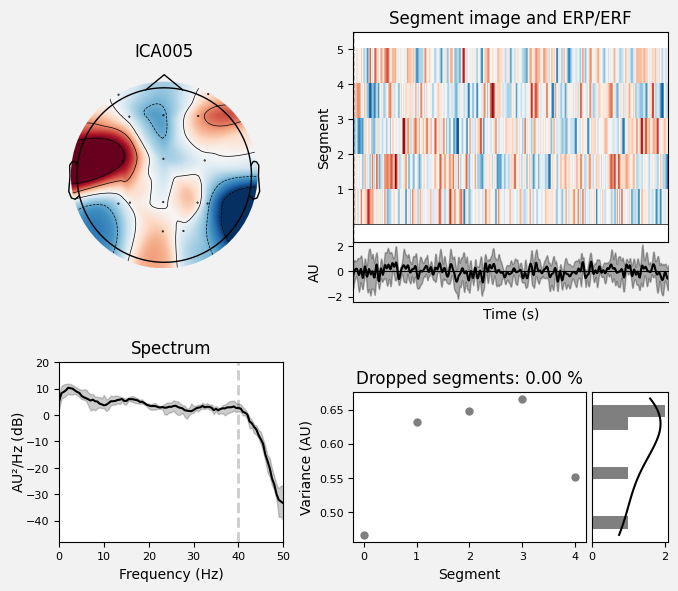

In [54]:
#Get each component
for i in range(0,6):
    a.plot_properties(b, picks=i)

(2525,)


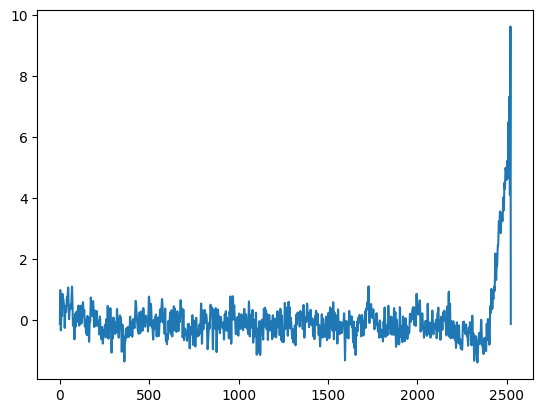

(2525,)


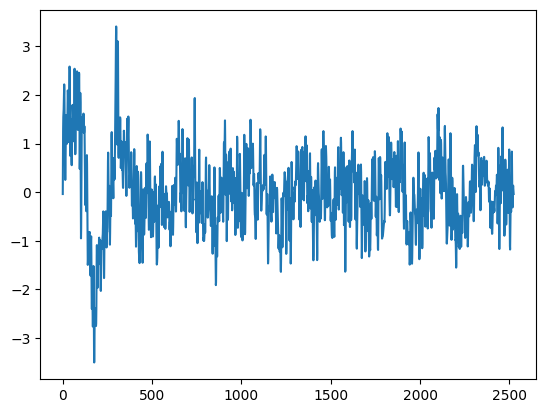

(2525,)


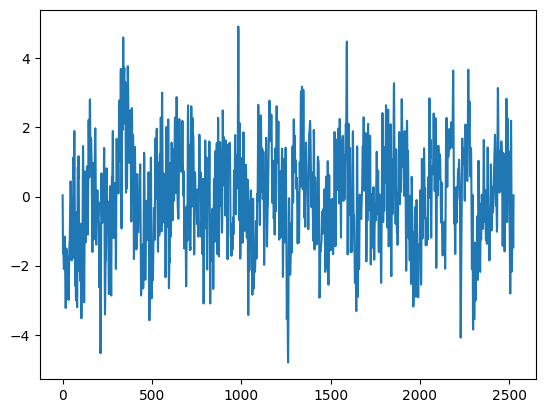

(2525,)


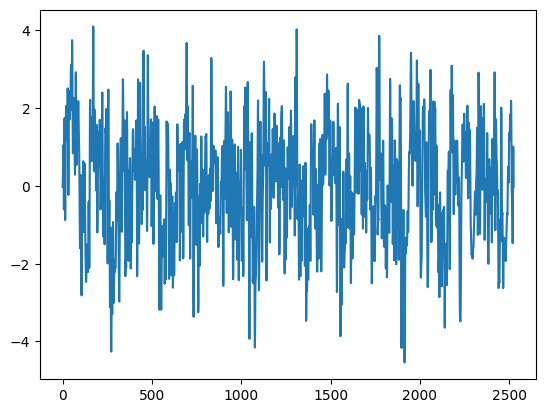

(2525,)


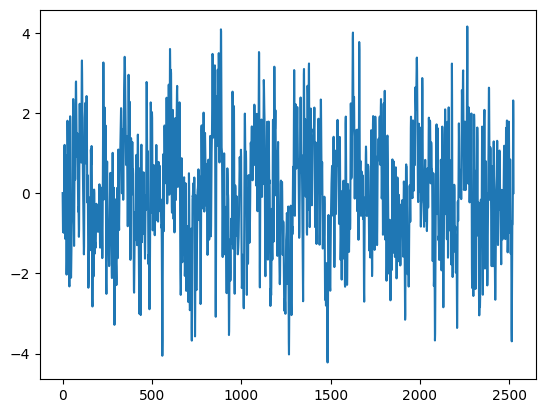

(2525,)


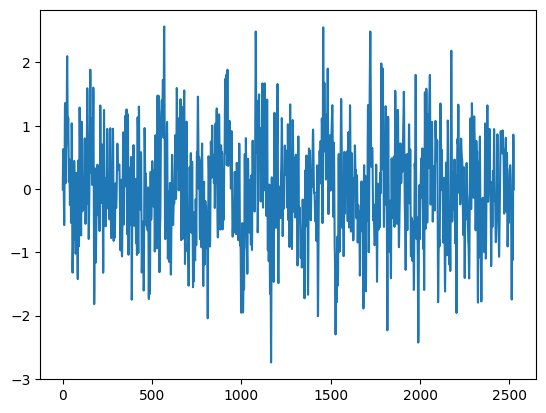

In [60]:
#Get into a vector the data of each component
for i in range(0,6):
    print(a.get_sources(b).get_data()[i].shape)
    #Plot it in a graph
    plt.plot(a.get_sources(b).get_data()[i])
    plt.show()